# ETITAN_2007

- **Paper**: 3D Convective Storm Identification, Tracking, and Forecasting - An Enhanced TITAN Algorithm

- $\textbf{\textcolor{red}{Identification}}$:
    + **Segmentation**: 
        + Multiple thresholds
        + Apply *mathematical morphology*: erode to eliminate false merge, dilate to fill the stronger storm within the storm with lower dBz bounded
    
    + **Feature representation**:
        + *The same as `TITAN_1993`*

- $\textbf{\textcolor{blue}{Tracking}}$:
    + **Motion estimation**: Estimate the composite motion vector-field using TREC - Correlation. For each block in curr frame, search for local region with max corr:
        + *Search space*: local region with bounded velocity.
        + *Vector motion*: point to region with max corr.
    
    + **Matching**: implement a 2-stage tracking:
        + *1st*: forecast using correlation: if 2 storms are ovelapped much, they are from the same track. For unmatched storm, we process them  in step 2.
        + *2nd*: Hungarian matching is applied with the dynamic constraint on the displacement bounded. 

        + *Handling split & merge*: the same as `TITAN_1993`.

- $\textbf{\textcolor{yellow}{Nowcasting}}$: instead of using centroid displacement => use estimated vector motion from TREC.
    + Avg value is used as the estimated vector motion of each storm
    + For other paramters => the same.

In [86]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

## Prepare dataset

In [150]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm

SOURCE_PATH = "data/image_old/philippines_13.269_123.832"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:40]

img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]

Number of frames: 40


## 1. Identification

In [ ]:
from src.identification import MorphContourIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.base import StormObject, StormsMap
from datetime import datetime
from shapely import Polygon
from scipy.signal import correlate2d
from skimage.measure import block_reduce

class CentroidStorm(StormObject):
    centroid: np.ndarray
    estimated_movement: tuple[float, float] = None

    def __init__(self, polygon: Polygon, centroid: tuple[float, float], id: str=""):
        super().__init__(contour=polygon, id=id)
        self.centroid = np.array(centroid)
    
    def retrieve_movement(self, **kargs):
        """
        Retrieve movement of the current storm by combining movement from
        """
        if self.estimated_movement is not None:
            return self.estimated_movement

        # retrieve parameters of estimatied-motion map.
        grid_y = kargs.get("grid_y", np.array([]))
        grid_x = kargs.get("grid_x", np.array([]))
        vy = kargs.get("vy", np.array([]))
        vx = kargs.get("vx", np.array([]))

        if len(grid_y) == 0:
            return np.array([0,0])

        block_size = int(grid_y[0] * 2)

        contours = convert_polygons_to_contours([self.contour])
        mask = np.zeros(img_shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, contours, color=1)

        crop_mask = mask[0:block_size * len(grid_y), 0:block_size * len(grid_x)]

        block_mask = block_reduce(crop_mask, block_size=(block_size,block_size), func=np.sum)
        total = np.sum(block_mask) + 1e-8
        dy = np.sum(vy * block_mask) / total
        dx = np.sum(vx * block_mask) / total

        self.estimated_movement = (dy, dx)

        return dy, dx

class DbzStormsMap(StormsMap):
    storms: list[CentroidStorm]
    dbz_map: np.ndarray

    def __init__(self, storms: list[CentroidStorm], time_frame: datetime, dbz_map: np.ndarray):
        """
        Beside 2 default attributes, also keep track of `dbz_map` for computin correlation.
        """
        super().__init__(storms, time_frame)
        self.dbz_map = dbz_map

    def _retrieve_movement(self, block: np.ndarray, search_region: np.ndarray) -> np.ndarray:
        block = block.astype(np.float32)
        search_region = search_region.astype(np.float32)
        result = cv2.matchTemplate(search_region, block, cv2.TM_CCOEFF_NORMED)
        return np.unravel_index(np.argmax(result), result.shape)

    
    def trec_estimate(self, other: "DbzStormsMap", **kargs) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Generate a correlation map which show the movement between the current to other storm map.
        """
        block_size = kargs.get("block_size", 16)
        stride = kargs.get("stride", 16)
        local_buffer = kargs.get("buffer", 50)      # search region = block + expanded by local_buffer

        dbz_map_1 = self.dbz_map
        dbz_map_2 = other.dbz_map
        H, W = dbz_map_2.shape

        ys = list(range(0, H-block_size+1, stride))     # ys: list[start_idx of H-axis]
        xs = list(range(0, W-block_size+1, stride))     # xs: list[start_idx of W-axis]

        vy = np.zeros(shape=(len(ys), len(xs)))         # vy: keep the y-value of movement at corresponding position
        vx = np.zeros_like(vy)                          # vx: keep the y-value of movement at corresponding position

        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                block = dbz_map_1[y:y+block_size, x:x+block_size]
                if np.std(block) < 1e-3:    # case std is too small => continue
                    continue

                # otherwise: get the search region
                y_search_low, y_search_high = max(0,y-local_buffer), min(H,y + block_size + local_buffer)   # ensure the seach region is not overflow.
                x_search_low, x_search_high = max(0,x-local_buffer), min(W,x + block_size + local_buffer)

                search_region = dbz_map_2[y_search_low:y_search_high, x_search_low:x_search_high]
                dy, dx = self._retrieve_movement(block, search_region)

                y_best, x_best = y_search_low + dy, x_search_low + dx
                vy[i][j] = y_best - y
                vx[i][j] = x_best - x
        
        # Get the center of the block
        grid_y = np.array(ys) + block_size / 2
        grid_x = np.array(xs) + block_size / 2

        for storm in self.storms:
            storm.retrieve_movement(grid_y=grid_y, grid_x=grid_x, vy=vy, vx=vx)

        return grid_y, grid_x, vy, vx

In [152]:
# --- 1. Generate a dbz_block (the "storm" pattern) ---
block = np.array([
    [12.1, 16.5, 21.3, 28.4, 33.2],
    [14.8, 21.7, 28.9, 35.7, 38.9],
    [10.9, 18.8, 27.5, 35.1, 40.0],
    [ 8.6, 14.3, 22.1, 30.2, 34.8],
    [ 6.5, 10.8, 16.4, 24.5, 28.7]
])

# --- 2. Generate a search_region ---
search_region = np.array([
    [ 5.0,  5.3,  5.5,  6.1,  6.8,  8.2, 10.1,  8.5,  6.0,  4.9,  4.7,  4.5],
    [ 5.1,  5.6,  6.0,  7.2,  9.0, 14.8, 20.5, 15.2,  9.4,  5.9,  5.0,  4.6],
    [ 5.3,  6.1,  7.4, 10.8, 18.9, 28.1, 35.5, 28.3, 16.8,  7.2,  5.4,  4.9],
    [ 5.0,  6.7, 10.2, 17.4, 27.8, 35.2, 39.8, 33.7, 20.2,  9.3,  6.3,  5.0],
    [ 5.0,  6.5,  9.3, 15.8, 25.5, 33.8, 38.4, 32.8, 18.4,  8.2,  5.7,  5.1],
    [ 4.9,  6.0,  7.9, 12.5, 20.5, 28.1, 34.1, 29.4, 15.1,  7.0,  5.4,  4.9],
    [ 4.8,  5.4,  6.4,  9.0, 14.7, 21.5, 27.0, 23.8, 12.1,  6.3,  5.2,  4.8],
    [ 4.7,  5.1,  5.5,  6.4,  8.7, 12.3, 15.8, 14.7,  9.8,  6.8,  6.1,  5.8],
    [ 4.6,  4.8,  5.0,  5.5,  6.5,  7.8,  9.5, 10.4, 13.2, 17.6, 21.4, 22.8],
    [ 4.6,  4.7,  4.8,  5.0,  5.5,  6.3,  7.8, 10.2, 18.3, 30.5, 40.8, 46.9],
    [ 4.6,  4.7,  4.8,  5.0,  5.3,  5.9,  7.0, 10.0, 21.4, 38.8, 50.0, 47.5],
    [ 4.5,  4.6,  4.7,  4.9,  5.2,  5.8,  6.8,  9.3, 18.5, 33.6, 44.2, 42.3]
])

a = block.shape[0]
    
# Normalize the block
block_mean = np.mean(block)
block_std = np.std(block)
if block_std < 1e-6:
    raise ValueError("Block has near-zero variance — NCC undefined.")
block_norm = (block - block_mean) / block_std

# Compute numerator using correlation
numerator = correlate2d(search_region, block_norm, mode='valid')

# Compute denominator (local std of search windows)
kernel = np.ones(block.shape)
local_sum = correlate2d(search_region, kernel, mode='valid')
local_sum_sq = correlate2d(search_region**2, kernel, mode='valid')
local_mean = local_sum / block.size
local_std = np.sqrt(np.maximum(local_sum_sq / block.size - local_mean**2, 1e-6))

# Normalize correlation
corr = numerator / (local_std * block.size)

corr, np.unravel_index(corr.argmax(), corr.shape)

(array([[ 0.53215655,  0.54833823,  0.53348963,  0.31072   , -0.20431966,
         -0.65021155, -0.80461248, -0.77335589],
        [ 0.77709061,  0.82306716,  0.83926611,  0.66261442, -0.0562377 ,
         -0.66143161, -0.82669675, -0.78574089],
        [ 0.89760191,  0.95789777,  0.98884905,  0.8933214 ,  0.05693255,
         -0.64064489, -0.81022542, -0.76848958],
        [ 0.79538608,  0.85483907,  0.88388034,  0.77037115,  0.13583593,
         -0.47943639, -0.7028023 , -0.70478903],
        [ 0.68196479,  0.72949153,  0.75318054,  0.65346947,  0.19678175,
         -0.32278105, -0.57307663, -0.605002  ],
        [ 0.57209538,  0.60617787,  0.62391486,  0.55458514,  0.25198895,
         -0.10400691, -0.24373425, -0.22057852],
        [ 0.49573255,  0.50104875,  0.51377677,  0.4860304 ,  0.37282799,
          0.24128301,  0.18613097,  0.11865277],
        [ 0.56442401,  0.54050498,  0.56260684,  0.63479516,  0.67469418,
          0.6186958 ,  0.59743999,  0.51299933]]),
 (np.int64(2),

In [153]:
THRESHOLD = 35
FILTER_AREA = 20    # storm with area under this threshold => cancel

Processing images and detecting storms: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


--------------------
Time: 2025-01-08 03:10:44 | Detected storms: 12
Time: 2025-01-08 03:16:44 | Detected storms: 13
Time: 2025-01-08 03:22:45 | Detected storms: 17
Time: 2025-01-08 03:28:45 | Detected storms: 12
Time: 2025-01-08 03:34:45 | Detected storms: 12
Time: 2025-01-08 03:40:45 | Detected storms: 14
Time: 2025-01-08 03:46:46 | Detected storms: 14
Time: 2025-01-08 03:52:46 | Detected storms: 13
Time: 2025-01-08 03:58:46 | Detected storms: 12
Time: 2025-01-08 04:04:46 | Detected storms: 14
Time: 2025-01-08 04:10:47 | Detected storms: 13
Time: 2025-01-08 04:16:47 | Detected storms: 14
Time: 2025-01-08 04:22:47 | Detected storms: 23
Time: 2025-01-08 04:28:47 | Detected storms: 15
Time: 2025-01-08 04:34:48 | Detected storms: 15
Time: 2025-01-08 04:40:48 | Detected storms: 11
Time: 2025-01-08 04:46:48 | Detected storms: 9
Time: 2025-01-08 04:52:48 | Detected storms: 17
Time: 2025-01-08 04:58:49 | Detected storms: 15
Time: 2025-01-08 05:04:49 | Detected storms: 14
Time: 2025-01-08 05:

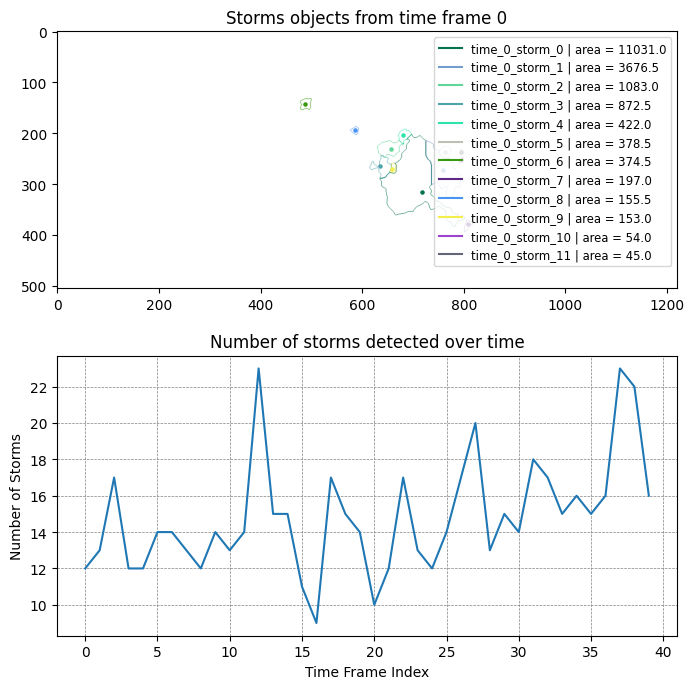

In [154]:
identifier = MorphContourIdentifier()
storms_map_time_lst: list[DbzStormsMap] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map, n_thresh=3, threshold=THRESHOLD, filter_area=FILTER_AREA)
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")

    # Keep list of storms
    storms = []

    for idx, polygon in enumerate(polygons):
        contour = convert_polygons_to_contours([polygon])[0]

        # Create the mask of current storm
        mask = np.zeros_like(dbz_map, dtype=np.uint8)
        cv2.fillPoly(mask, contour, color=1)

        # Extract DBZ values inside mask
        weights = dbz_map * mask

        # Create coordinate grids
        y_idx, x_idx = np.indices(dbz_map.shape)

        # Compute weighted centroid
        total_weight = weights.sum()
        if total_weight == 0:
            centroid = (np.nan, np.nan)  # or fallback
        else:
            cx = (x_idx * weights).sum() / total_weight
            cy = (y_idx * weights).sum() / total_weight
            centroid = (int(cx), int(cy))

        storms.append(CentroidStorm(
                polygon, centroid=centroid, id=f"time_{time_idx}_storm_{idx}"
            ))
        
    storms_map = DbzStormsMap(storms, time_frame=time_frame, dbz_map=dbz_map)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    # x_centroid, y_centroid = storm.contour.centroid.x, storm.contour.centroid.y
    x_centroid, y_centroid = storm.centroid
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(loc="upper right", fontsize='small', ncol=1)
plt.imshow(blank_image,cmap="grey")
plt.title('Storms objects from time frame 0')
plt.legend(loc="upper right", fontsize='small', ncol=1)


plt.subplot(2,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

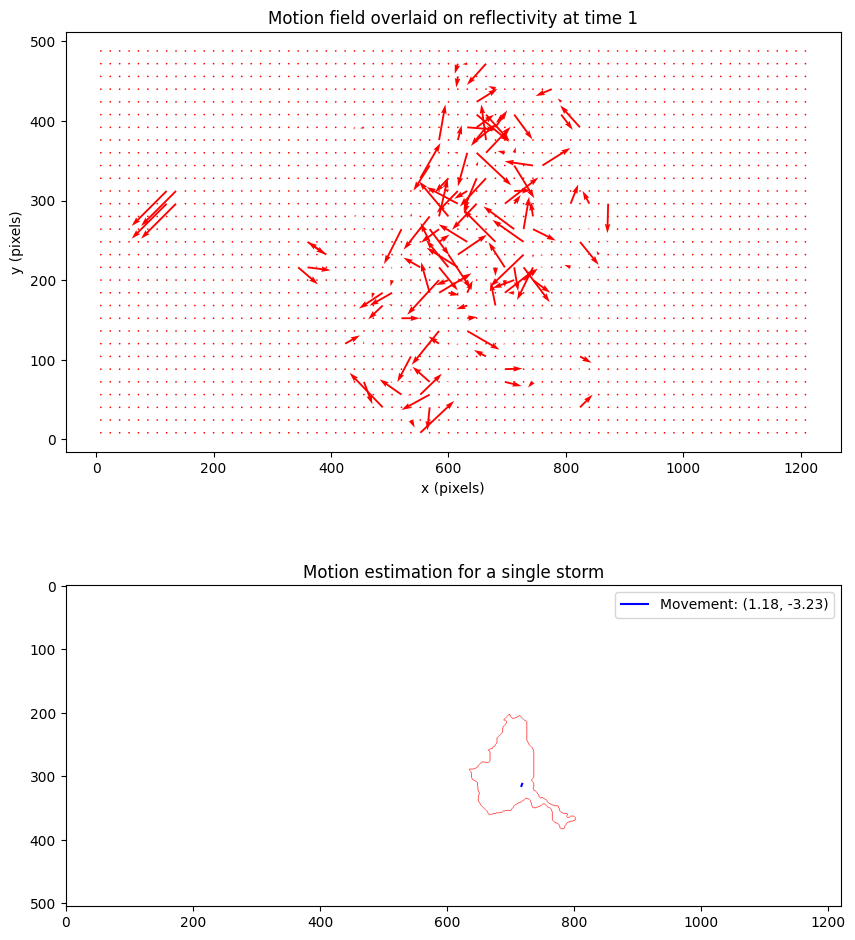

In [ ]:
storms_map_1 = storms_map_time_lst[0]
storms_map_2 = storms_map_time_lst[1]
block_size = 16
grid_y, grid_x, vy, vx = storms_map_1.trec_estimate(storms_map_2, block_size=block_size, stride=block_size)

plt.figure(figsize=(10,12))

plt.subplot(2,1,1)
# Plot motion vectors
plt.quiver(
    grid_x, grid_y,        # vector positions (centers of blocks)
    vx, vy,                # vector components (dx, dy)
    # angles="xy", 
    scale_units="xy", 
    scale=1,
    color="red", 
    # width=0.003
)

plt.title(f"Motion field overlaid on reflectivity at time {1}")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")

plt.subplot(2,1,2)
storm = storms_map_1.storms[0]
contours = convert_polygons_to_contours([storm.contour])

blank_image = np.ones(img_shape, np.uint8) * 255
cv2.drawContours(blank_image, contours, -1, (255,0,0))
y_centroid, x_centroid = storm.centroid
dy, dx = storm.retrieve_movement(grid_y=grid_y, grid_x=grid_x, vy=vy, vx=vx)
plt.plot([y_centroid, y_centroid+dy], [x_centroid, x_centroid+dx], color=(0,0,1), label=f"Movement: ({dy:.2f}, {dx:.2f})")
plt.title(f"Motion estimation for a single storm")
plt.legend()
plt.imshow(blank_image)

plt.tight_layout
plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Idea**: implement a 2-stage matching:

    1. Motion estimaton using TREC + overlapping technique
    
    2. Hungarian matching for those failures.

In [ ]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker
from typing import Callable
from shapely.affinity import translate
from src.cores.similarity import area_overlapping_ratio

class Matcher(BaseMatcher):
    dynamic_max_velocity: Callable[[float], float]      # dynamic constraint for maximum velocity

    def __init__(self, dynamic_max_velocity: Callable[[float], float]):
        self.dynamic_max_velocity = dynamic_max_velocity
    
    def _construct_disparity_matrix(
            self, storm_lst1: list[CentroidStorm], storm_lst2: list[CentroidStorm]
        ) -> tuple[np.ndarray, np.ndarray]:
        """
        Construct the cost matrix for Hungarian matching.
        """
        # get square root of area difference
        area_lst1 = np.array([storm.contour.area for storm in storm_lst1])
        area_lst2 = np.array([storm.contour.area for storm in storm_lst2])
        area_matrix = np.sqrt(np.abs(area_lst1[:, None] - area_lst2[None, :]))

        # get centroid displacement
        centroid_lst1 = np.array([storm.centroid for storm in storm_lst1])
        centroid_lst2 = np.array([storm.centroid for storm in storm_lst2])
        centroid_displacement_matrix = np.linalg.norm(centroid_lst1[:,None,:] - centroid_lst2[None,:,:], axis=2)
        
        return area_matrix + centroid_displacement_matrix, centroid_displacement_matrix
    
    def match_storms(
            self, storm_map_1: DbzStormsMap, storm_map_2: DbzStormsMap, 
            correlation_block_size: int = 16, matching_overlap_threshold: float = 0.5
        ) -> np.ndarray:
        """
        Match storms between 2 time frame.

        Args:
            storm_map_1 (StormsMap): storm map in the 1st frame.
            storm_map_2 (StormsMap): storm map in the 2nd frame.
        
        Returns:
            assignments (np.ndarray): Array of (prev_idx, curr_idx) pairs representing matched storms.
        """
        prev_num_storms = len(storm_map_1.storms)
        curr_num_storms = len(storm_map_2.storms)
        
        # Step 1: matching using Hungarian matching.
        grid_y, grid_x, vy, vx = storms_map_1.trec_estimate(storms_map_2, block_size=correlation_block_size, stride=correlation_block_size)
        curr_polygons = [storm.contour for storm in storm_map_2.storms]

        prev_matched_set = set()
        curr_matched_set = set()

        assignments = []
        for i, prev_storm in enumerate(storm_map_1.storms):
            dx, dy = prev_storm.retrieve_movement(grid_y=grid_y, grid_x=grid_x, vy=vy, vx=vx)
            pred_pol = translate(prev_storm.contour, xoff=dx, yoff=dy)
            
            scores = [area_overlapping_ratio(pred_pol, curr_pol, mode='avg') for curr_pol in curr_polygons]
            matching_indices = np.argwhere(np.array(scores) > matching_overlap_threshold)
            if len(matching_indices) > 0:
                prev_matched_set.add(i)
                for matching_idx in matching_indices:
                    curr_matched_set.add(int(matching_idx[0]))

            assignments.extend([(i, matching_idx[0]) for matching_idx in matching_indices])

        prev_matched = list(prev_matched_set)
        curr_matched = list(curr_matched_set)

        assignments = np.array(assignments)

        ## case: all storms are matched, or 1 side is fully matched
        if len(prev_matched) == prev_num_storms or len(curr_matched) == curr_num_storms:
            return assignments
        
        # Step 2: perform 2nd matching for unmatched storms 
        cost_matrix, displacement_matrix = self._construct_disparity_matrix(storm_map_1.storms, storm_map_2.storms)

        ## adjust the cost matrix
        dt = (storm_map_2.time_frame - storm_map_1.time_frame).seconds / 3600     # unit: hr
        invalid_mask = np.ones_like(cost_matrix, dtype=bool)

        for i in range(prev_num_storms):
            # case: storm i in prev is already matched => continue
            if i in prev_matched:
                continue
            for j in range(curr_num_storms):
                # case: storm j in curr is already matched => continue
                if j in curr_matched:
                    continue

                # check for dynamic velocity constraint
                max_area = max(storm_map_1.storms[i].contour.area, storm_map_2.storms[j].contour.area)
                max_displacement = self.dynamic_max_velocity(max_area) * dt
                if displacement_matrix[i][j] <= max_displacement:
                    invalid_mask[i][j] = 0

        cost_matrix = cost_matrix + invalid_mask * 1e6
        row_ind, col_ind = self._hungarian_matching(cost_matrix)

        assignment_mask = np.zeros_like(cost_matrix, dtype=bool)
        assignment_mask[row_ind, col_ind] = True

        assignments_2 = np.argwhere(assignment_mask & np.logical_not(invalid_mask))

        # print(f"Number of matched: {len(assignments_2)}")

        return np.concatenate([assignments, assignments_2], axis=0)

In [157]:
def dynamic_max_velocity(area: float) -> float:
    """
    Dynamic constraint for maximum velocity based on storm area. The unit of velocity is pixel/hr.
    """
    if area < 300:
        return 500
    elif area < 500:
        return 750
    else:
        return 1000

matcher = Matcher(dynamic_max_velocity=dynamic_max_velocity)
assignments = matcher.match_storms(storms_map_time_lst[0], storms_map_time_lst[1])
assignments

array([[ 0,  0],
       [ 1,  1],
       [ 2,  2],
       [ 3,  3],
       [ 4,  7],
       [ 5,  4],
       [ 6,  6],
       [ 7,  5],
       [10, 10],
       [11, 11],
       [ 9,  8]])

### 2.2 Implementation of `TrackingHistory`

- **Idea**: keep track of storms evolution over time.

- **Public methods**:
    - $\textcolor{yellow}{\text{forecast}}$: forecast the next position of current storm track.
    - $\textcolor{yellow}{\text{update}}$: receive the mapping of current storms and update the track.

In [158]:
from copy import deepcopy
from shapely.affinity import translate

class TrackingHistory(BaseTrackingHistory):
    def __init__(self, storms_map: StormsMap):
        self.tracks = [self._initialize_track(storm, storms_map.time_frame) for storm in storms_map.storms]
        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.storm_dict)))
    
    def _initialize_track(self, storm: CentroidStorm, time_frame: datetime):
        return {"storm_lst": [storm], "frame": [time_frame], "movement": []}
    
    def _get_track(self, storm_id: str) -> tuple[dict, float]:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track, is_active (tuple(dict, float))
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id], track_id in self.active_list
    
    def _interpolate_velocity(self, velocity_lst: list[np.ndarray], alpha_decay: float = 0.5):
        if len(velocity_lst) == 1:
            return velocity_lst[0]
        
        weights = np.array([alpha_decay**i for i in range(len(velocity_lst))])
        total_w = np.sum(weights)
        return np.sum([displ * w / total_w for displ, w in zip(velocity_lst[::-1], weights)], axis=0)

    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> CentroidStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track, is_active = self._get_track(storm_id)
        if not is_active:
            print(f"⚠️ Storm has been expired")
            
        curr_storm = track["storm_lst"][-1]

        velocity_lst = track["movement"]
        if len(velocity_lst) == 0:      # if no recorded velocity => use the default motion.
            velocity_lst = [default_motion]
        
        dx, dy = self._interpolate_velocity(velocity_lst) * dt
        new_pol = translate(curr_storm.contour, xoff=dx, yoff=dy)
        new_centroid = curr_storm.centroid + np.array(dx, dy)

        return CentroidStorm(new_pol, centroid=new_centroid)

    def _handle_merge(self, merge_lst: list[dict]) -> np.ndarray:
        """
        Combine the list of storms to generate the parent storm history.
        
        Args:
            merge_lst (list[dict]): contains information about the storm, including movement history, area.
        """
        weights = np.array([s["area"] for s in merge_lst])
        movements_lst = [np.array(s["movement"])[::-1] for s in merge_lst]  # revert for matching the time.

        combined_len = max([len(movements) for movements in movements_lst]) # length of parent = max length of its child
        parent_movement = np.zeros(shape=(combined_len, 2), dtype=np.float64)

        # for each time, if the
        for i in range(combined_len):
            total_value, total_weight = np.zeros(shape=(2,)), 0
            for weight, movements in zip(weights, movements_lst):
                if len(movements) <= i:
                    continue
                total_value += movements[i]
                total_weight += weight
            parent_movement[i] = total_value / total_weight
        
        return parent_movement[::-1]
    
    def _handle_split(self):
        pass

    def update(
            self, prev_mapping: dict, curr_mapping: dict, prev_storms_map: DbzStormsMap, curr_storms_map: DbzStormsMap,
        ):
        """
        Update the tracking history using the new mapping data.

        Args:
            prev_mapping (dict): key -> idx of prev storm; items -> list[idx of curr storm].
            curr_mapping (dict): key -> idx of curr storm; items -> list[idx of prev storm].
            time_frame (datetime): time of current mapping.
        """
        active_lst = []         # update the new active list
        curr_time = curr_storms_map.time_frame
        prev_time = prev_storms_map.time_frame

        dt = (curr_time - prev_time).seconds / 3600

        def get_movement(prev_idx, curr_idx):
            """
            Get the centroid movement of 2 storms, scaled to pixel/hr.
            """
            displacement = prev_storms_map.storms[prev_idx].retrieve_movement()
            if displacement is None:
                raise ValueError(f"Storm {prev_storms_map.storms[prev_idx].id} is None")
            
            return np.array(displacement) / dt

        for curr_idx, matched in curr_mapping.items():
            curr_storm = curr_storms_map.storms[curr_idx]

            ## Case 1: no previous matching => create the new track.
            if len(matched) == 0:
                # create new track
                self.tracks.append(self._initialize_track(curr_storm, curr_time))

                # update storm dict and active_lst
                new_tid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_tid
                active_lst.append(new_tid)
            
            # Case 2: more than 1 parent storms => merged
            elif len(matched) > 1:
                merge_lst = []
                max_area = 0
                track_id = None

                for prev_idx in matched:
                    prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                    track = self._get_track(prev_storm.id)[0]          # get the corresponding track
                    area = prev_storm.contour.area
                    if area > max_area:
                        max_area = area
                        track_id = self.storm_dict[prev_storm.id]   # track with highest area will be extended, others are terminated
                    
                    merge_lst.append({
                        "area": prev_storm.contour.area,
                        "movement": track["movement"] + [get_movement(prev_idx, curr_idx)]
                    })
                
                current_track = self.tracks[track_id]
                
                movement_history = self._handle_merge(merge_lst)    # resolve the history
                current_track["storm_lst"].append(curr_storm)
                current_track["movement"] = list(movement_history)  # update the movement
                current_track["frame"].append(curr_time)

                # update storm dict & active lst
                active_lst.append(track_id)
                self.storm_dict[curr_storm.id] = track_id
            
            # Case 3: only 1 parent storm
            else:
                prev_idx = matched[0]
                prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                # case 3.1: parent has more than 2 childrens => split
                #   => movement = combined centroid - previous storm centroid
                if len(prev_mapping[prev_idx]) > 1:
                    # get the combined centroid using area as weight.
                    weight_centroids = [(curr_storms_map.storms[j].centroid, curr_storms_map.storms[j].contour.area) \
                                          for j in prev_mapping[prev_idx]]
                    total_w = np.sum([w for _, w in weight_centroids])
                    combined_centroid = np.sum([centroid * w / total_w for centroid, w in weight_centroids], axis=0)

                    # get the movement from parent -> combined centroid
                    movement = (combined_centroid - prev_storm.centroid) / dt

                    # copy the previous track into the new, then update parameters.
                    new_track = deepcopy(self._get_track(prev_storm.id)[0])
                    self.tracks.append(new_track)
                    new_track["storm_lst"].append(curr_storm)
                    new_track["movement"].append(movement)
                    new_track["frame"].append(curr_time)

                    new_tid = len(self.tracks) - 1
                    self.storm_dict[curr_storm.id] = new_tid
                    active_lst.append(new_tid)

                # case 3.2: one-to-one parent-child
                else:
                    # update the current track
                    movement = get_movement(prev_idx, curr_idx)
                    current_track = self._get_track(prev_storm.id)[0]
                    current_track["storm_lst"].append(curr_storm)
                    current_track["movement"].append(movement)
                    current_track["frame"].append(curr_time)

                    track_id = self.storm_dict[prev_storm.id]
                    self.storm_dict[curr_storm.id] = track_id
                    active_lst.append(track_id)

        self.active_list = sorted(active_lst)

    def print_tracks(self):
        for id, track in enumerate(self.tracks):
            print(f"Track {id:2d}. " + " -> ".join(storm.id for storm in track["storm_lst"]))
            print(f"Lifespan: {len(track["frame"])}")
            print(f"Last track: {track["frame"][-1].strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

In [161]:
from shapely import Point
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class Tracker(BaseTracker):
    matcher: Matcher
    tracker: TrackingHistory

    def __init__(self, dynamic_max_velocity: Callable[[float], float]):
        self.matcher = Matcher(dynamic_max_velocity)
        
    def fit(self, storms_map_time_lst: list[StormsMap], test=False):
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # scaled to hour

            # match using Hungarian algorithm
            assignments = self.matcher.match_storms(prev_storms_map, curr_storms_map)

            # resolve merge & split
            ## mapping: dict where key -> index of storm; value -> list of tuple[storm_id]
            mapping_prev = {}
            mapping_curr = {}
            for prev_idx, curr_idx in assignments:
                if int(prev_idx) not in mapping_prev:
                    mapping_prev[int(prev_idx)] = []
                mapping_prev[int(prev_idx)].append(int(curr_idx))

                if int(curr_idx) not in mapping_curr:
                    mapping_curr[int(curr_idx)] = []
                mapping_curr[int(curr_idx)].append(int(prev_idx))


            prev_assigned, curr_assigned = mapping_prev.keys(), mapping_curr.keys()
            prev_unassigned = [idx for idx in range(len(prev_storms_map.storms)) if idx not in prev_assigned]
            curr_unassigned = [idx for idx in range(len(curr_storms_map.storms)) if idx not in curr_assigned]


            if len(prev_unassigned) > 0 or len(curr_unassigned) > 0:  # if any unassigned => resolve
                pred_storms_map = StormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame)

                # Check for merging
                for prev_idx in prev_unassigned:
                    pred_storm = pred_storms_map.storms[prev_idx]

                    # Find storms that the predicted centroid fall into.
                    candidates = [
                            idx for idx, storm in enumerate(curr_storms_map.storms) \
                                if storm.contour.contains(Point(pred_storm.centroid))
                        ]
                    
                    # Case: more than 1 candidates => choose one with maximum overlapping on prev_storm
                    if len(candidates) > 1:
                        def compute_overlapping(pol: Polygon):
                            return pred_storm.contour.intersection(pol) / pred_storm.contour.area
                        
                        max_idx = np.argmax([compute_overlapping(curr_storms_map.storms[j].contour) \
                                                for j in candidates])
                        candidates = [candidates[max_idx]]
                    
                    mapping_prev[prev_idx] = candidates
                    for cand_idx in candidates:
                        if cand_idx not in mapping_curr:
                            mapping_curr[cand_idx] = []
                        mapping_curr[cand_idx].append(prev_idx)
                
                # Check for splitting
                for curr_idx in curr_unassigned:
                    curr_storm = curr_storms_map.storms[curr_idx]
                    # Find predicted storms that the current centroid fall into.
                    candidates = [
                            idx for idx, storm in enumerate(pred_storms_map.storms) \
                                if storm.contour.contains(Point(curr_storm.centroid))
                        ]
                    
                    # Case: more than 1 candidates => choose one with maximum overlapping on prev_storm
                    if len(candidates) > 1:
                        def compute_overlapping(pol: Polygon):
                            return curr_storm.contour.intersection(pol).area / curr_storm.contour.area
                        
                        max_idx = np.argmax([compute_overlapping(pred_storms_map.storms[i].contour) \
                                                for i in candidates])
                        candidates = [candidates[max_idx]]
                    
                    mapping_curr[curr_idx] = [cand_idx for cand_idx in candidates]
                    for cand_idx in candidates:
                        if cand_idx not in mapping_prev:
                            mapping_prev[cand_idx] = []
                        mapping_prev[cand_idx].append(curr_idx)
            
            if test:
                pred_storms_map = StormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame)
                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            self.tracker.update(mapping_prev, mapping_curr, prev_storms_map, curr_storms_map)
        
        if test:
            return csi_scores, far_scores, pod_scores, frames
    
    def predict(self, storm: CentroidStorm, dt: float):
        try:
            return self.tracker.forecast(storm.id, dt)
        except KeyError:
            print(f"❗ Storm not found on the track. `None` will be returned.")
            return None

In [162]:
MAX_VELOCITY = 500  # unit: pixel/hr

def dynamic_max_velocity(area: float) -> float:
    """
    Dynamic constraint for maximum velocity based on storm area. The unit of velocity is pixel/hr.
    """
    if area < 300:
        return 500
    elif area < 500:
        return 750
    else:
        return 1000

tracker = Tracker(dynamic_max_velocity=dynamic_max_velocity)
csi_scores, far_scores, pod_scores, frames = tracker.fit(storms_map_time_lst, test=True)

tracker.tracker.print_tracks()

Track  0. time_0_storm_0 -> time_1_storm_0
Lifespan: 2
Last track: 2025-01-08 03:16:44
--------------------------------------------------
Track  1. time_0_storm_1 -> time_1_storm_1 -> time_2_storm_8 -> time_3_storm_7 -> time_4_storm_2 -> time_5_storm_0 -> time_6_storm_0
Lifespan: 7
Last track: 2025-01-08 03:46:46
--------------------------------------------------
Track  2. time_0_storm_2 -> time_1_storm_2 -> time_2_storm_10 -> time_3_storm_4 -> time_4_storm_8 -> time_5_storm_13
Lifespan: 6
Last track: 2025-01-08 03:40:45
--------------------------------------------------
Track  3. time_0_storm_3 -> time_1_storm_3 -> time_2_storm_3
Lifespan: 3
Last track: 2025-01-08 03:22:45
--------------------------------------------------
Track  4. time_0_storm_4 -> time_1_storm_7 -> time_2_storm_13 -> time_3_storm_10 -> time_4_storm_11 -> time_5_storm_8 -> time_6_storm_8 -> time_7_storm_4 -> time_8_storm_2 -> time_9_storm_2 -> time_10_storm_1 -> time_11_storm_1
Lifespan: 12
Last track: 2025-01-08 04

## 3. Nowcasting

In [163]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

indexes = range(len(bm_pod_scores))
scores = [bm_pod_scores, bm_far_scores, bm_csi_scores]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9208 | FAR: 0.0847 | CSI: 0.8485
	Time 2025-01-08 03:22:45 | POD: 0.7951 | FAR: 0.5425 | CSI: 0.4093
	Time 2025-01-08 03:28:45 | POD: 0.8738 | FAR: 0.1553 | CSI: 0.7528
	Time 2025-01-08 03:34:45 | POD: 0.8885 | FAR: 0.1713 | CSI: 0.7506
	Time 2025-01-08 03:40:45 | POD: 0.6773 | FAR: 0.5021 | CSI: 0.4024
	Time 2025-01-08 03:46:46 | POD: 0.8721 | FAR: 0.1395 | CSI: 0.7640
	Time 2025-01-08 03:52:46 | POD: 0.4474 | FAR: 0.5720 | CSI: 0.2800
	Time 2025-01-08 03:58:46 | POD: 0.8381 | FAR: 0.2410 | CSI: 0.6619
	Time 2025-01-08 04:04:46 | POD: 0.7846 | FAR: 0.1959 | CSI: 0.6587
	Time 2025-01-08 04:10:47 | POD: 0.6986 | FAR: 0.3581 | CSI: 0.5027
	Time 2025-01-08 04:16:47 | POD: 0.8409 | FAR: 0.1589 | CSI: 0.7256
	Time 2025-01-08 04:22:47 | POD: 0.4131 | FAR: 0.6499 | CSI: 0.2338
	Time 2025-01-08 04:28:47 | POD: 0.7194 | FAR: 0.3865 | CSI: 0.4951
	Time 2025-01-08 04:34:48 | 

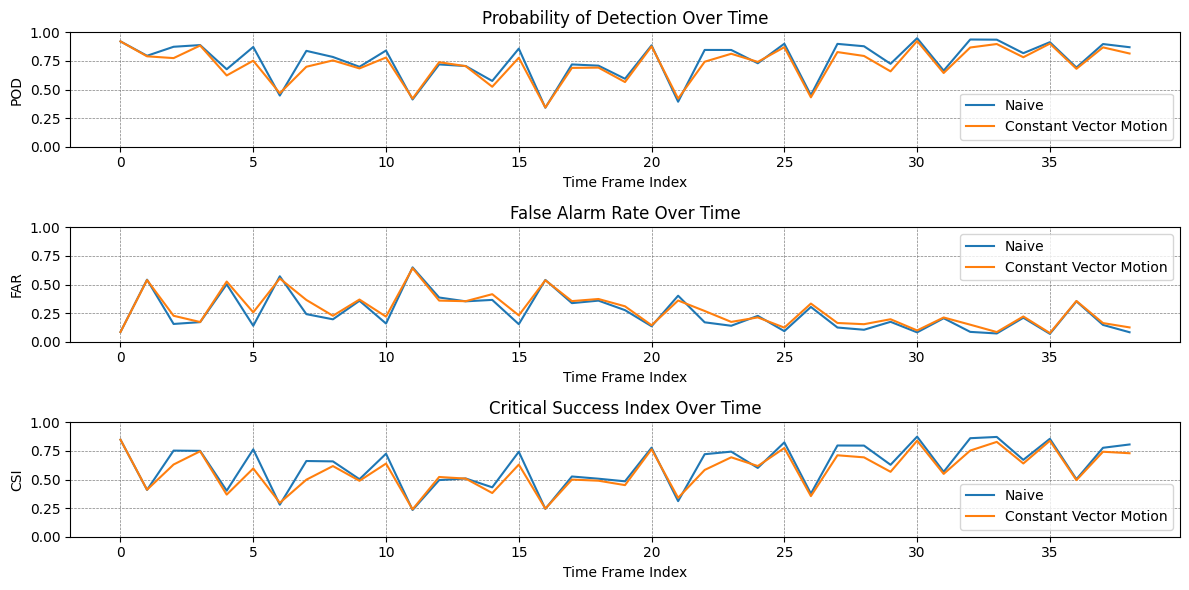

In [164]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()